In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier

import sys
sys.path.append('../')

from DataAnalysis.Framework.MyDf import MyDf
from DataAnalysis.Framework.FunctsMeta import initMeta, addMeta, copyMeta
from DataAnalysis.Framework.Predict import Predict
from DataAnalysis.ImputeProp import ImputeProp

## My Issues with data science in python

### A. Slicing
You have different column types: features you would like to transform during feature engineering, and targets. Typically you also have IDs you would like to take along such as the customer number. 

How to store them? In one table? Then you have to slice vertically every time you want to take out features. In multiple tables? Then you have to have to operate on several tables all the time.

### B. Variable types
You want to transform all the integer variables... However, in numpy all nullable number variables -- those with missing values -- are floats (that is booleans and integers) And what about numerical labels? How to identify those?
Can we store var types somewhere?

### C. Debugging
For instance when I write my own transformers, I would like to find errors very early on and not 10 functions down the line. Can I check the integrity of my dataset somehow after every step?

When I package the data into pipelines and there is an error, how can I get quickly down to the error without rerunning the code again.

### D. Explaining the data
My Regressor/Classifier tells me that row one is important. What does that mean? Can I somehow find out which transformations the feature underwent?

I only want to take out those variables which are important for my Regressor/Classifier. So which ones were those before the feature engineering?  

## My Solution

I was trying to get to a solution in which I can decouple the coding from the data science work. There should be times during which I write transformers and code. Then there are times during which I can focus on the data science the business the usecase without needing to deal with code. The code should then by my ship that carries me.

Have a pair of two tables -- currently pandas data frames, but could also support numpy, dask or spark dataframes --  one contains the data one contains metadata and tracks feature types, changes to the features.

### 1a. Initiate the MyDataframe

In [6]:
##create a random dataSet
nRows = 300
props = pd.DataFrame({
    "custId": np.random.randint(1,50, nRows),
    "salesDay": np.random.randint(1,50, nRows),
    "salesWeekday": np.random.randint(1, 7, nRows),
    "salesVol": np.random.randint(0,1000, nRows)/100,
    "volume_0": np.random.randint(0,1000, nRows)/100,
    "volume_1": np.random.randint(0,1000, nRows)/100,
    "volume_2": np.random.randint(0,1000, nRows)/100
})

## lets add some Nulls here
props.salesDay.iloc[:10] = np.nan


## Create the MetaData with the custom functions making your like easy. We will discuss the details later
meta = initMeta()
meta = addMeta(meta, "custId", "nZ", Type_col = "id")
meta = addMeta(meta, "salesDay", "nZ", Nullable = True, NonNullPerc = 10/50, Type_col = "feat")
meta = addMeta(meta, "salesWeekday", "nLabel", Type_col = "feat")
meta = addMeta(meta, "salesVol", "nR", Type_col = "feat")
meta = addMeta(meta, "volume_0", "nR", IsTimeVar = True, TimeVarIdx = 0, NameUnderlying = "volume", Type_col = "feat")
meta = addMeta(meta, "volume_1", "nR", IsTimeVar = True, TimeVarIdx = 1, NameUnderlying = "volume", Type_col = "feat")
meta = addMeta(meta, "volume_2", "nR", IsTimeVar = True, TimeVarIdx = 2, NameUnderlying = "volume", Type_col = "feat")


## So now lets check the dat
data = MyDf()
data.setData(props, meta)


MyDf, setData:Are you sure you want to use this? Normally you should not


C:\Users\bc5190\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


ValueError: Exactly 1 used target por favor! Der er 0

The code is deliberately very unforgiving so every potential error is found early. 

It also has a nice Message Service which lets you easily write a lot of code. The idea is to push a lot of information to the console. When you see that a transformer transformed 0 features, you might want to conclude that something went different from your expectations and you should change the code or the parameters.

So what went wrong here? We dont have a target, but this code comes from the world of classification so unless you state you do not want one, it complains...

Let's fix this!



In [7]:
props["target"] = np.random.randint(0, 2, nRows)
## The target has to be non-null boolean, so lets make this happen
props["target"] = props["target"].astype("bool")

meta = addMeta(meta, "target", "bool", Type_col = "target")

data.setData(props, meta)

MyDf, setData:Are you sure you want to use this? Normally you should not


..\DataAnalysis\Framework\MyDf.py:189: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  types = types.reindex_axis(self._correctCols, axis = 1)


## 1b. Creating the initial DataFrame in reality

I coded a class which collects information from various sources, such as the SQL Infoschema, and creates the inital data frame for you

    baseInfo = MyBaseInfo(typeVarFunct = abtTypeVar)
    baseInfo.addSqlInfoSchema(server = server, db = db, table = tableNameShort)
    baseInfo.getNullsFromPickles(readProps, lims.getAvailDataRange())
    baseInfo.setNameUnderlyingAbtStyle()
    baseInfo.addSheetInfoSchema(readAbtSheet, joinOn = "NameUnderlying")
    baseInfo.addInferInfoSchema(readProps, lims.getAvailDataRange()[-1])
    baseInfo.testVariables()
    baseInfo.createTypeVar()

## 1c. Final Words 
So we solved issue B, we have a way to track the variable types a

## 2. Getting the data

You can get the the data back out of the frame with the getData function

It can slice the DataFrame in various ways:

In [8]:
props, meta = data.getData()
print("All Columns:", props.columns.tolist())

props, meta = data.getData(colTypes = ["target"])
print("colTypes = ['target']:", props.columns.tolist())

props, meta = data.getData(varTypes = ["nZ"])
print("varTypes = ['nZ']:", props.columns.tolist())

All Columns: ['custId', 'salesDay', 'salesWeekday', 'salesVol', 'volume_0', 'volume_1', 'volume_2', 'target']
colTypes = ['target']: ['target']
varTypes = ['nZ']: ['custId', 'salesDay']


## 3. The MetaData

Lets look what is in the metadata frame

In [9]:
props, meta = data.getData()
meta

,NameId,NameUnderlying,IsTimeVar,TimeVarIdx,IsUsed,IsDeleted,Type_col,Type_var,Nullable,NonNullPerc,NameInit,IsTimeVarInit,Def,Trafos,Desc,FeatsUnderlying
0,custId,custId,False,NaN,True,False,id,nZ,False,1.0,custId,False,,,,custId
1,salesDay,salesDay,False,NaN,True,False,feat,nZ,True,0.2,salesDay,False,,,,salesDay
2,salesWeekday,salesWeekday,False,NaN,True,False,feat,nLabel,False,1.0,salesWeekday,False,,,,salesWeekday
3,salesVol,salesVol,False,NaN,True,False,feat,nR,False,1.0,salesVol,False,,,,salesVol
4,volume_0,volume,True,0.0,True,False,feat,nR,False,1.0,volume_0,False,,,,volume_0
5,volume_1,volume,True,1.0,True,False,feat,nR,False,1.0,volume_1,False,,,,volume_1
6,volume_2,volume,True,2.0,True,False,feat,nR,False,1.0,volume_2,False,,,,volume_2
7,target,target,False,NaN,True,False,target,bool,False,1.0,target,False,,,,target


- NameId: The current NameID
- NameUnderlying: This is for timeseries data and lag variabls. What variable is it which we are looking at
- IsTimeVar: Is it part of a time series set
- TimeVarIdx: Which time series index is it
- IsUsed, IsDeleted: you can set variables to unused and or delete them. This will be tracked in the metadata
- Type_col: Is it a feature, a target or an ID
- Type_var: What is var type
- Nullable, NonNullPerc: Is the variable nullable and how many Null do we expect
- NameInit, IsTimeVarInit: When we started the process how did the data look like
- Def: This is to write down what the variable is about
- Trafos: JSON string to tack the transformations
- Desc: JSON string to tack the feature importance (coming from the Classifiers)
- FeatsUnderlying: Tracking the path of the variable through the process

In [10]:
## some extra tracking of what is going on
data.baseInfo()

MyDf, baseInfo:Number entries:  300
Perc Ones:       46.67%
Number feats:    7
Number feats underyling: 5
NumberFeats unused:      0
NumberFeats deleted:     0


## 4. Transform the data

Normally you would send your features and target into a sci-kit transformer and expect the the transformed feature and target frame to be returned.

The new dataframe is mutable. You pass the dataFrame to the transformer and nothing is returned. The advantage is that if the transformer throws an error you now have access to the last data going into the transformer before the error (think of pipelines)

In [11]:
## lets get the time vars and turn them into the mean
props, meta = data.getData(onlyTimeVars = True)

## we only have the volums so that is easy... create a new column mean
props["volume_mean"] = props.mean(axis = 1)

## Now lets register the changes in the metadata

meta = copyMeta(meta, "volume", 
    NameId = "volume_mean",
    Type_var = 'nR',
    Trafos = [{"className": "DemoTrends", "classType": "TrendCont", "params": {"operation": "std"}}],
    IsTimeVar = False,
    FeatsUnderlying = ["volume_0", "volume_1", "volume_2"],
    setOldToUnused = True
)

## now merge it back into the data

data.setDataSlice(props, meta)


C:\Users\bc5190\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
..\DataAnalysis\Framework\MyDf.py:189: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  types = types.reindex_axis(self._correctCols, axis = 1)


 So let's see what we have done:
 - The volume_xx are gone, instead we have a new variable which has a transformation log as well as some additional underying features...

In [12]:
props, meta = data.getData()
meta

,NameId,NameUnderlying,IsTimeVar,TimeVarIdx,IsUsed,IsDeleted,Type_col,Type_var,Nullable,NonNullPerc,NameInit,IsTimeVarInit,Def,Trafos,Desc,FeatsUnderlying
0,custId,custId,False,NaN,True,False,id,nZ,False,1.0,custId,False,,,,custId
1,salesDay,salesDay,False,NaN,True,False,feat,nZ,True,0.2,salesDay,False,,,,salesDay
2,salesWeekday,salesWeekday,False,NaN,True,False,feat,nLabel,False,1.0,salesWeekday,False,,,,salesWeekday
3,salesVol,salesVol,False,NaN,True,False,feat,nR,False,1.0,salesVol,False,,,,salesVol
7,target,target,False,NaN,True,False,target,bool,False,1.0,target,False,,,,target
8,volume_mean,volume,False,NaN,True,False,feat,nR,False,1.0,volume_0,False,,"[{""className"": ""DemoTrends"", ""classType"": ""Tre...",,"volume_0, volume_0, volume_1, volume_2"


 ## 4b. How to write a real transformer
 Below is an excerpt of one of my transformers

In [13]:
from DataAnalysis.Framework.AbstractTransform import AbstractTransform, kwargsAbsTrafo


class TrendCont(AbstractTransform):
    """
    The trends are created out of the time variables are generated for continous variables

    Args: 
        iPython: bool=True, Standard option for disabling the iPhython widget in production
        keepOldVars: bool=True, keep the old time vars, if false will only keep the '_0'
    """  

    def __init__(self, **kwargs):
        super().__init__("TrendCont", **reduceKwargs(kwargs, kwargsAbsTrafo))
        checkKwargs(kwargs, kwargsAbsTrafo + ['keepOldVars'])
        self._keepOldVars = kwargs.get('keepOldVars', True)
        
        self._completeSets = None

    def fit(self, data):
        stat = StatusBars(self._message, methodName = "fit").start("")

        self._completeSets = findCompleteSets(data, stat, varTypes =  ['nZ', 'nR'])

        stat.stop()
    
    def transform(self, data):
        stat = StatusBars(self._message, methodName = "transform").start("")
        
        props, meta = data.getData(onlyNameUnderlyings = self._completeSets)
        
        trendDF = pd.DataFrame([])

        stat.barInit(len(self._completeSets))
        for feat in self._completeSets:
            stat.barUp(feat)
            metaEntries = meta[(meta.NameUnderlying == feat) & meta.TimeVarIdx.isin([0, 1, 2, 3])]
            anotb, _, bnota = intersection(metaEntries.TimeVarIdx.tolist(), [0, 1, 2, 3])
            if len(anotb) > 0 or len(bnota) > 0:
                stat.errMessage("{0} does not have the time vars 0,1,2,3 but {1}".format(feat, ", ".join(metaEntries.TimeVarIdx.astype(str))))
            colNames = metaEntries.sort_values("TimeVarIdx").NameId
                             
            joinedMeta = { 
                'setOldToUnused': False, 'IsUsed': True, 
                'IsTimeVar': False,
                'FeatsUnderlying':  colNames,
                "messageBridge": self._message, 
                "ifStrict": self._ifStrict
            }      
                  
            trendDF[feat + "_mean"] =  props[colNames].mean(axis = 1)
            
            ##register _0 and set all originals to Unused
            if not self._keepOldVars:
                meta = setMeta(meta, feat, IsUsed = False)
            
            meta = copyMeta(meta, feat, NameId = feat + "_mean", **joinedMeta, 
                Type_var = 'nR', Trafos = shortCutSerTrafo(self, {"operation": "mean"}),
                **calcNulls(meta, feat, [0, 1, 2, 3])                  
            )
            
        stat.split("Save new vars...").barClose()
        data.setDataSlice(trendDF, meta)
        stat.stop()


## 5. How does that all help the explanation?

### 5.a Lets get a quick prediction out




In [14]:
## before predicting we still need to get rid of the null... 
## We want to retain information about the nulls so we create a boolean
imp = ImputeProp(["salesDay"], 0, excludeTrafos = ["TrendBool", "TrendCont"], ifCreateEx = True )
imp.fitTransform(data)

ImputeProp, fit:Start.
ImputeProp, fit:Done. Time 0:00:00.020003
ImputeProp, transform:Start.
ImputeProp, transform:1 variables will be imputed
ImputeProp, transformLabels:Start.


..\DataAnalysis\ImputeProp.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  props[propName + "_ex"] = props[propName].notnull()
..\DataAnalysis\Framework\MyDf.py:189: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  types = types.reindex_axis(self._correctCols, axis = 1)


Text(value='')

FloatProgress(value=0.0, max=1.0)

ImputeProp, transformLabels:Done. Time 0:00:00.410414
ImputeProp, transform:Done. Time 0:00:00.591493


..\DataAnalysis\BinningFuncts_TransformTest.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  props[newNameId] = outProp.astype(int)


In [15]:
graBoo = GradientBoostingClassifier()
pred = Predict(graBoo, className = 'GraBoo')

pred.fitTransform(data)

GraBoo:FeatVault needed before using.
GraBoo, fit:Start.
GraBoo, fit:Done. Time 0:00:00.087519
GraBoo, transform:Start.
GraBoo, transform:Split. Time 0:00:00.025002, Now: PredictProba found: predicting proba
GraBoo, transform:Split. Time 0:00:00.085056, Now: Saving weights
GraBoo, transform:Done. Time 0:00:00.083029


..\DataAnalysis\Framework\Predict.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  feats['predProba' + self._className] = predProba
..\DataAnalysis\Framework\Predict.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  feats['pred' + self._className] = pred
..\DataAnalysis\Framework\MyDf.py:189: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  types = types.reindex_axis(self._correctCols, axis = 1)


In [16]:
props, meta = data.getData()
meta

,NameId,NameUnderlying,IsTimeVar,TimeVarIdx,IsUsed,IsDeleted,Type_col,Type_var,Nullable,NonNullPerc,NameInit,IsTimeVarInit,Def,Trafos,Desc,FeatsUnderlying
0,custId,custId,False,NaN,True,False,id,nZ,False,1.0,custId,False,,,,custId
2,salesWeekday,salesWeekday,False,NaN,True,False,feat,nLabel,False,1.0,salesWeekday,False,,,"[{""classType"": ""GraBoo"", ""className"": ""GraBoo""...",salesWeekday
3,salesVol,salesVol,False,NaN,True,False,feat,nR,False,1.0,salesVol,False,,,"[{""classType"": ""GraBoo"", ""className"": ""GraBoo""...",salesVol
7,target,target,False,NaN,True,False,target,bool,False,1.0,target,False,,,,target
8,volume_mean,volume,False,NaN,True,False,feat,nR,False,1.0,volume_0,False,,"[{""className"": ""DemoTrends"", ""classType"": ""Tre...","[{""classType"": ""GraBoo"", ""className"": ""GraBoo""...","volume_0, volume_0, volume_1, volume_2"
9,salesDay_ex,salesDay,False,NaN,True,False,feat,bool,False,1.0,salesDay,False,,"[{""className"": ""ImputeProp"", ""classType"": ""Imp...","[{""classType"": ""GraBoo"", ""className"": ""GraBoo""...","salesDay, salesDay"
10,salesDay_imp,salesDay,False,NaN,True,False,feat,nZ,False,1.0,salesDay,False,,"[{""classType"": ""ImputeProp"", ""className"": ""Imp...","[{""classType"": ""GraBoo"", ""className"": ""GraBoo""...","salesDay, salesDay"
11,predGraBoo,predGraBoo,False,NaN,True,False,score,scPred,False,1.0,predGraBoo,False,GraBoo Prediction,,,"salesWeekday,salesVol,volume_mean,salesDay_ex,..."
12,predProbaGraBoo,predProbaGraBoo,False,NaN,True,False,score,scProba,False,1.0,predProbaGraBoo,False,GraBoo Probability,,,"salesWeekday,salesVol,volume_mean,salesDay_ex,..."


So the class Predict has added two columns to the data.. these are the scores of the GradientBoost, that is pred and predProba. 

Also the Desc column is not filled with the feature importances

C:\Users\bc5190\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


<IPython.core.display.Javascript object>


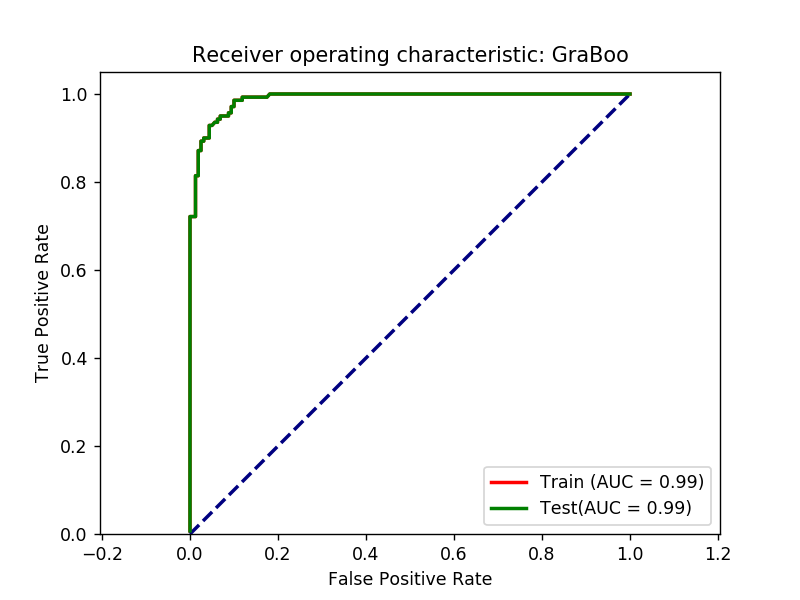

<IPython.core.display.Javascript object>


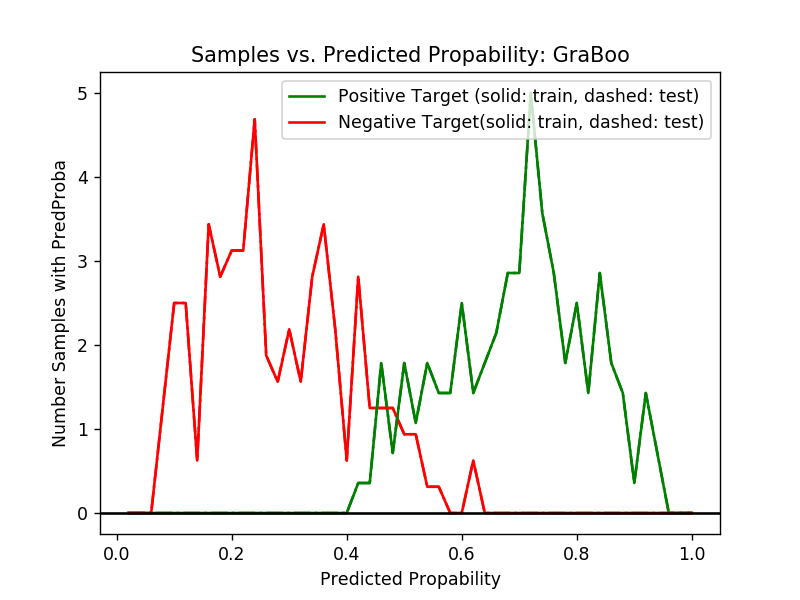

<IPython.core.display.Javascript object>


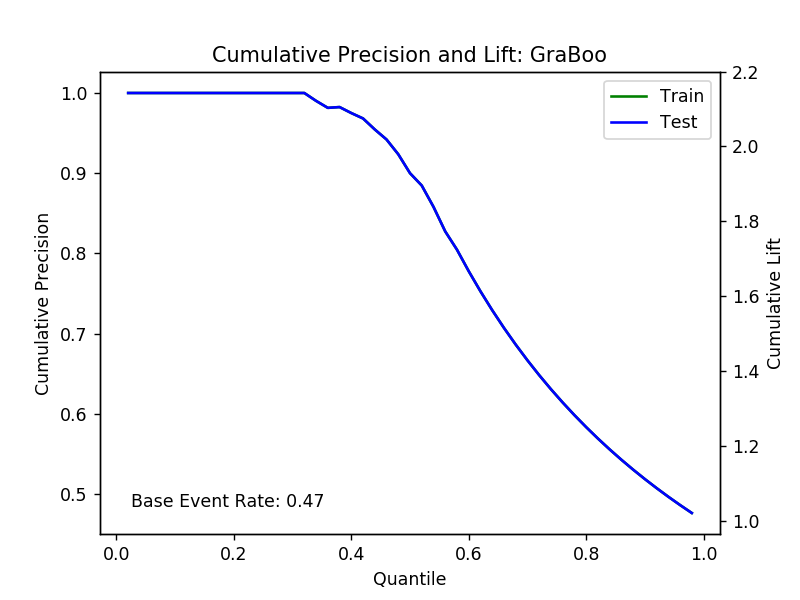

<IPython.core.display.Javascript object>


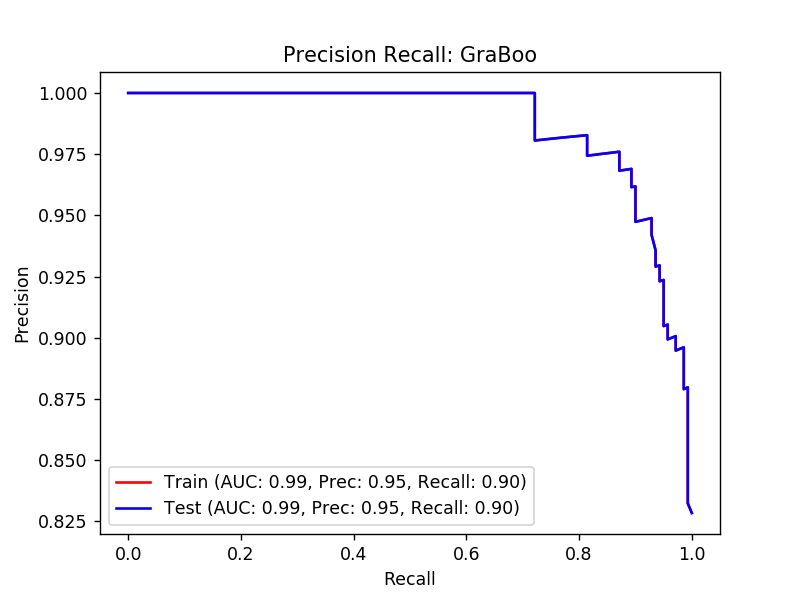

<IPython.core.display.Javascript object>


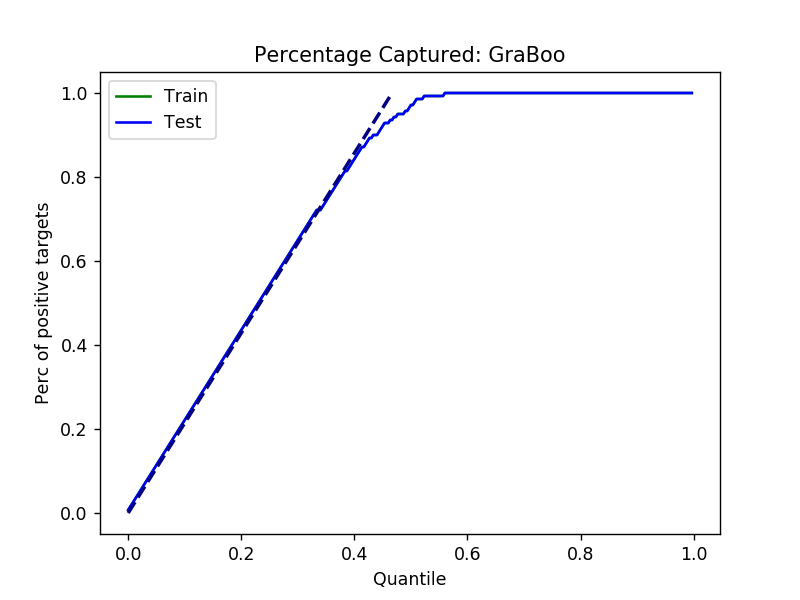

In [17]:
%matplotlib notebook
from DataAnalysis.Plots.Roc import rocCurvePlot
from DataAnalysis.Plots.PredProba import predProbaPlot
from DataAnalysis.Plots.Lift import liftCurvePlot
from DataAnalysis.Plots.PrecRecall import precRecCurvePlot
from DataAnalysis.Plots.PercCaptured import percCapturedPlot


noBins = 50

##----------------------------
for modelName in ['GraBoo']: #
    props, _ = data.getData()
    fullOutTrain = props[['target', 'predProba' + modelName, 'pred' + modelName ]]
    fullOutTrain.rename(columns={'predProba' + modelName: 'predProba', 'pred' + modelName: 'pred'}, inplace = True)

 
    roc =  rocCurvePlot(fullOutTrain, fullOutTrain, label = modelName)
    pred = predProbaPlot(fullOutTrain, fullOutTrain, noBins = noBins, label = modelName)
    lift = liftCurvePlot(fullOutTrain, fullOutTrain, noBins = noBins, label = modelName)
    prec = precRecCurvePlot(fullOutTrain, fullOutTrain, label = modelName)
    perc = percCapturedPlot(fullOutTrain, fullOutTrain, label = modelName)
    
 #   roc.savefig(pickleLocation('doc', fileBaseOut + "_RocPlot" + modelName, hasEnd = False)[2] + '.png')
 #   pred.savefig(pickleLocation('doc', fileBaseOut + "_PredPlot" + modelName, hasEnd = False)[2] + '.png')
 #   lift.savefig(pickleLocation('doc', fileBaseOut + "_LiftPlot" + modelName, hasEnd = False)[2] + '.png')
 #   prec.savefig(pickleLocation('doc', fileBaseOut + "_PrecPlot" + modelName, hasEnd = False)[2] + '.png')

  Woooop, almost prediction... smellls like overfitting. but who cares

### 5b. Now let's look how this helps with the feature importance

Because we have collected all the information about the Feature Importances into the Meta Data we can now read this information out and print out the important features no matter how many Classifiers we used. 

That can also be saved to an excel.

In [19]:
from DataAnalysis.WeightAnalysis import calcWeights, getUnderlyingFeatures

weights = calcWeights(data, ['LogReg', 'GraBoo'])
weightsBest = weights.sort_values("sum_points", ascending = False).iloc[:400]

In [20]:
weightsBest

,GraBoo_abs,GraBoo_rank,GraBoo_raw,GraBoo_weightType,NameId,NameUnderlying,GraBoo_points,GraBoo_pointsGrouped,sum_pointsGrouped,sum_points,Def,Trafos
1,0.478373,1.0,0.478373,featImp,salesVol,salesVol,4.0,4.0,4.0,4.0,,
2,0.442153,2.0,0.442153,featImp,volume_mean,volume,3.0,3.0,3.0,3.0,,"[{""className"": ""DemoTrends"", ""classType"": ""Tre..."
0,0.063030,3.0,0.063030,featImp,salesWeekday,salesWeekday,2.0,2.0,2.0,2.0,,
3,0.016444,4.0,0.016444,featImp,salesDay_ex,salesDay,1.0,1.0,1.0,1.0,,"[{""className"": ""ImputeProp"", ""classType"": ""Imp..."
4,0.000000,5.0,0.000000,featImp,salesDay_imp,salesDay,0.0,1.0,1.0,0.0,,"[{""classType"": ""ImputeProp"", ""className"": ""Imp..."


## 5c. The underlying features

Now we would like to only take out the features which are important to the model... we need this to speed up production. I typically reduce 1200 features to 300, so the prediction takes only 1/4th of the time 

getUnderlyingFeatures runs recursively through the metadata and finds the all the features in SQL which are needed to create the final variables

In [21]:
_, metaAll = data.getData(includeDeleted = True)
underlyingFeatures = getUnderlyingFeatures(metaAll, weightsBest.NameId)
underlyingFeatures

['salesVol',
 'volume_0',
 'volume_0',
 'volume_1',
 'volume_2',
 'salesWeekday',
 'salesDay',
 'salesDay',
 'salesDay',
 'salesDay']

We can see that "volume_mean" has been replaced by the 0-3 variables

## Back to my Issues with data science in python

### A. Slicing
The MyDf takes care of the slicing. Nothing to worry about on our side.

### B. Variable types
We centrally store the variable types in the MyDf metadata and can select different variable types.

### C. Debugging
The dataframe checks the the integrity of the data set during every "setData()" call.

We have a colourful messaging system which pushes a lot of information to the console / ipython.

### D. Explaining the data
Feature transformations are tracked, so when it comes down to explaining the model you have all the information you need at one place.